In [3]:
import os
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
import seaborn as sns



In [4]:

#upload model
model = YOLO('model/bcp_detector.pt')


🔍 Analyzing Image: 00001__1024__0___1648.png
📋 Ground Truth Components: 6
   - capacitor
   - capacitor
   - capacitor
   - capacitor
   - capacitor
   - capacitor
🎯 Predictions: 11
   - capacitor: 90.54%
   - capacitor: 90.21%
   - capacitor: 90.00%
   - capacitor: 89.88%
   - capacitor: 89.79%
   - capacitor: 89.27%
   - capacitor: 88.86%
   - capacitor: 88.78%
   - capacitor: 48.39%
   - capacitor: 37.55%
   - capacitor: 25.02%

📊 Image Statistics (Simplified):
   • Correct Detections (Class Match): 11
   • Precision: 1.000
   • Recall: 1.833


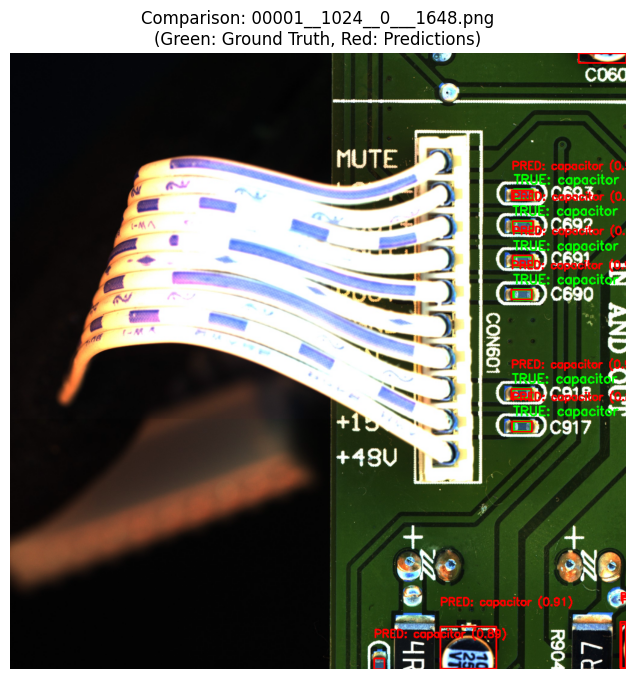


🔍 Analyzing Image: 00001__1024__1648___3296.png
📋 Ground Truth Components: 21
   - capacitor
   - resistor
   - capacitor
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - resistor
   - resistor
   - capacitor
   - resistor
   - capacitor
   - resistor
   - resistor
   - capacitor
   - resistor
   - capacitor
   - ic
🎯 Predictions: 26
   - ic: 92.69%
   - capacitor: 91.14%
   - capacitor: 91.00%
   - capacitor: 90.95%
   - capacitor: 90.20%
   - ic: 89.84%
   - capacitor: 89.61%
   - capacitor: 89.40%
   - resistor: 89.37%
   - resistor: 88.99%
   - capacitor: 88.94%
   - resistor: 88.90%
   - resistor: 88.85%
   - resistor: 88.74%
   - capacitor: 88.61%
   - resistor: 88.38%
   - resistor: 88.24%
   - resistor: 87.98%
   - resistor: 87.86%
   - ic: 87.05%
   - resistor: 86.85%
   - resistor: 86.64%
   - capacitor: 83.15%
   - resistor: 70.68%
   - diode: 43.03%
   - resistor: 30.40%

📊 Image Statistics (Simplified):
   • Correct 

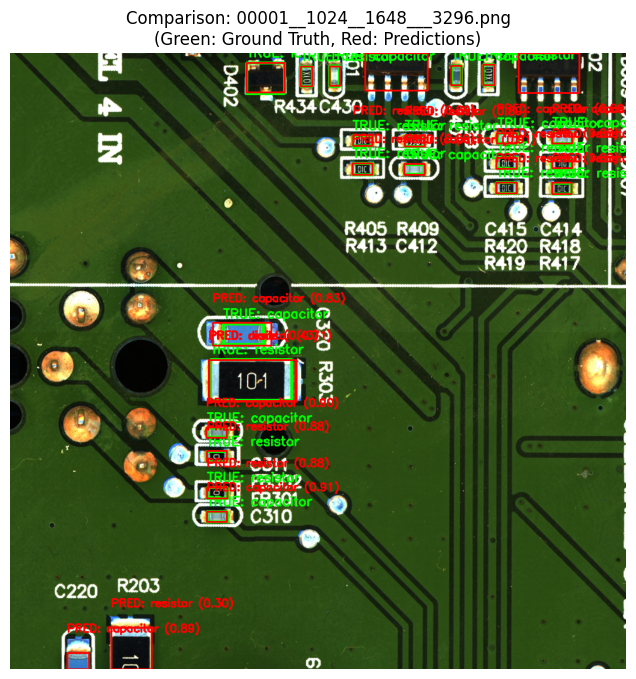


🔍 Analyzing Image: 00001__1024__2472___1648.png
📋 Ground Truth Components: 41
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - capacitor
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - capacitor
   - resistor
   - resistor
   - capacitor
   - capacitor
   - resistor
   - resistor
   - resistor
   - resistor
   - resistor
   - capacitor
   - capacitor
   - ic
🎯 Predictions: 42
   - ic: 94.71%
   - capacitor: 93.19%
   - capacitor: 91.62%
   - capacitor: 91.50%
   - capacitor: 91.44%
   - capacitor: 91.34%
   - capacitor: 91.06%
   - capacitor: 91.00%
   - capacitor: 90.75%
   - capacitor: 90.73%
   - resistor: 90.71%
   - capacitor: 90.55%
   - capacitor: 90.30%
   - resistor: 90.01%
   - capa

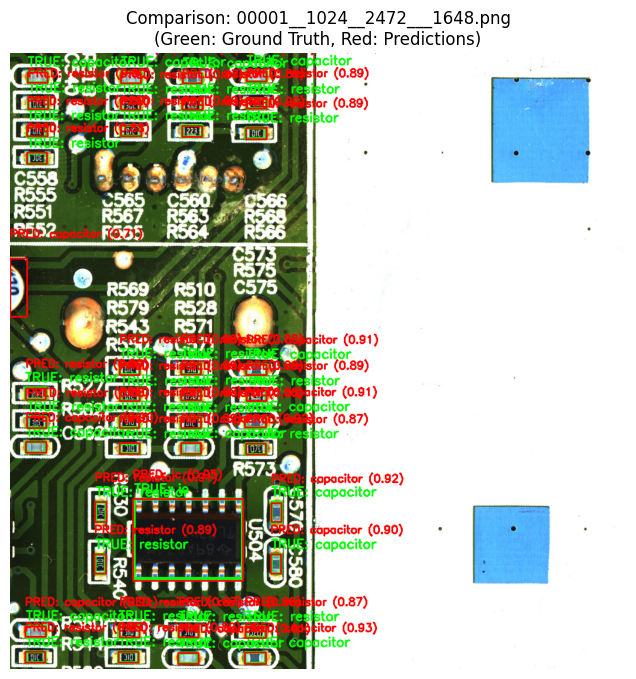

In [11]:


# NOTE: The 'model' object must be loaded successfully before this code runs.
# Example from previous steps (assuming the correct path for a local Windows environment):
# model = YOLO(r'F:\machine learning_SFIC\PCB\model\pcb_detector_v8m\weights\best.pt')

# --- Assuming 'model' is already loaded here ---

def read_yolo_labels(label_path, img_width=1024, img_height=1024):
    """Read a YOLO label file and return bounding boxes in pixel coordinates (xyxy)."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                if len(data) == 5:
                    class_id = int(data[0])
                    
                    # Convert normalized coordinates (0-1) to pixel coordinates
                    x_center = float(data[1]) * img_width
                    y_center = float(data[2]) * img_height
                    width = float(data[3]) * img_width
                    height = float(data[4]) * img_height
                    
                    # Convert to xyxy format (top-left x, y and bottom-right x, y)
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    boxes.append({
                        'class_id': class_id,
                        # NOTE: This line requires the global 'model' object to be loaded.
                        'class_name': model.names[class_id], 
                        'bbox': [x1, y1, x2, y2]
                    })
    return boxes

def visualize_comparison():
    """Perform a visual comparison between model predictions and ground truth."""
    test_images_dir = 'components_data_clean/test/images'
    test_labels_dir = 'components_data_clean/test/labels'
    
    image_files = os.listdir(test_images_dir)[:3]  # Test only 3 images
    
    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        # Assuming label files are .txt with the same stem as the image
        label_path = os.path.join(test_labels_dir, os.path.splitext(image_file)[0] + '.txt')
        
        print(f"\n🔍 Analyzing Image: {image_file}")
        print("=" * 50)
        
        # Read Ground Truth (GT) from labels
        true_boxes = read_yolo_labels(label_path)
        print(f"📋 Ground Truth Components: {len(true_boxes)}")
        for true in true_boxes:
            print(f"   - {true['class_name']}")
        
        # Model Prediction
        # conf=0.25 (minimum confidence threshold)
        results = model.predict(source=image_path, conf=0.25, imgsz=1024, verbose=False)
        
        pred_boxes = []
        for r in results:
            if r.boxes is not None:
                for box in r.boxes:
                    pred_boxes.append({
                        'class_id': int(box.cls[0]),
                        'class_name': model.names[int(box.cls[0])],
                        'bbox': box.xyxy[0].tolist(), # xyxy format (x1, y1, x2, y2)
                        'confidence': float(box.conf[0])
                    })
        
        print(f"🎯 Predictions: {len(pred_boxes)}")
        for pred in pred_boxes:
            print(f"   - {pred['class_name']}: {pred['confidence']:.2%}")
        
        # Load the original image for drawing
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Copy for drawing
        comparison_image = image.copy()
        
        # Draw Ground Truth (Green)
        for true in true_boxes:
            x1, y1, x2, y2 = map(int, true['bbox'])
            cv2.rectangle(comparison_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(comparison_image, f"TRUE: {true['class_name']}", 
                        (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Draw Predictions (Red)
        for pred in pred_boxes:
            x1, y1, x2, y2 = map(int, pred['bbox'])
            cv2.rectangle(comparison_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(comparison_image, f"PRED: {pred['class_name']} ({pred['confidence']:.2f})", 
                        (x1, y1 - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        
        # Calculate simple statistics (Note: This is an oversimplification, not true IoU matching)
        correct_detections = 0
        for pred in pred_boxes:
            for true in true_boxes:
                # Simple check: If the class names match, count it as correct (requires more complex IoU logic for true evaluation)
                if pred['class_name'] == true['class_name']:
                    correct_detections += 1
                    break
        
        precision = correct_detections / len(pred_boxes) if len(pred_boxes) > 0 else 0
        recall = correct_detections / len(true_boxes) if len(true_boxes) > 0 else 0
        
        print(f"\n📊 Image Statistics (Simplified):")
        print(f"   • Correct Detections (Class Match): {correct_detections}")
        print(f"   • Precision: {precision:.3f}")
        print(f"   • Recall: {recall:.3f}")
        
        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(comparison_image)
        plt.title(f'Comparison: {image_file}\n(Green: Ground Truth, Red: Predictions)')
        plt.axis('off')
        plt.show()

# Run the comparison
# NOTE: Ensure the 'model' object is loaded successfully before calling this function.
visualize_comparison()

🔍 Starting comprehensive analysis of all test images...
🔍 Analyzing 120 images in the test set...
📊 Processed 10/120 images
📊 Processed 20/120 images
📊 Processed 30/120 images
📊 Processed 40/120 images
📊 Processed 50/120 images
📊 Processed 60/120 images
📊 Processed 70/120 images
📊 Processed 80/120 images
📊 Processed 90/120 images
📊 Processed 100/120 images
📊 Processed 110/120 images
📊 Processed 120/120 images


C:\Users\User\AppData\Local\Temp\ipykernel_13432\883753220.py:244: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\anaconda3\envs\yolo_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


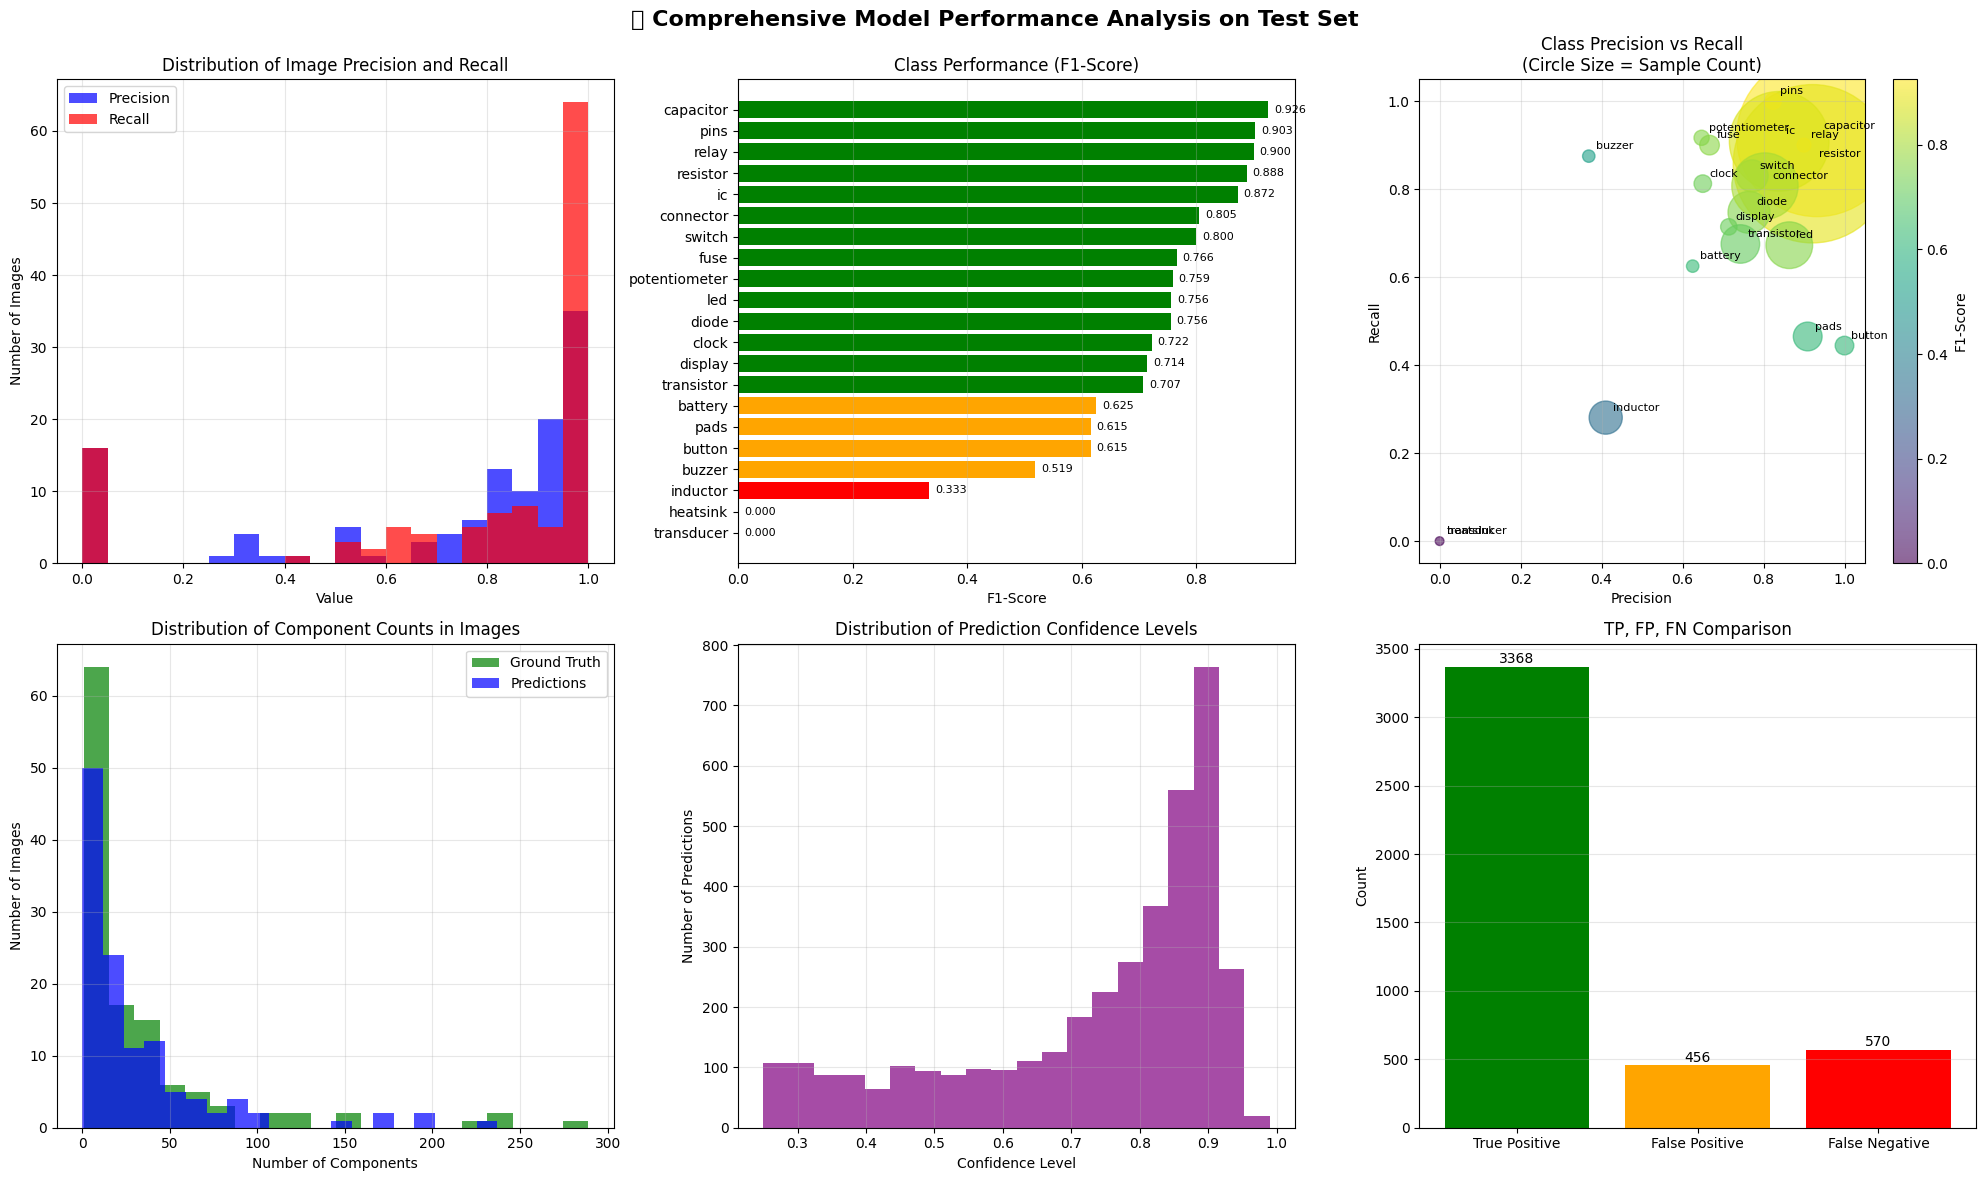


 📈 Comprehensive Model Performance Report

📊 General Statistics:
   • Total Images Analyzed: 120
   • Total True Components: 3938
   • Total Predictions: 3824
   • Total Correct Predictions (Class Match): 3368
   • Average Image Precision: 0.730
   • Average Image Recall: 0.782
   • Average Image F1-Score: 0.746

🎯 Top 5 Performing Classes:
   • capacitor      : F1=0.926, P=0.932, R=0.920
   • pins           : F1=0.903, P=0.824, R=1.000
   • relay          : F1=0.900, P=0.900, R=0.900
   • resistor       : F1=0.888, P=0.921, R=0.858
   • ic             : F1=0.872, P=0.839, R=0.909

⚠️ Worst 5 Performing Classes:
   • pads           : F1=0.615, P=0.909, R=0.465
   • buzzer         : F1=0.519, P=0.368, R=0.875
   • inductor       : F1=0.333, P=0.410, R=0.281
   • heatsink       : F1=0.000, P=0.000, R=0.000
   • transducer     : F1=0.000, P=0.000, R=0.000

📈 Class Performance Distribution:
   • Excellent (F1 ≥ 0.7): 14 classes
   • Good (0.5 ≤ F1 < 0.7): 4 classes
   • Poor (0.3 ≤ F1 < 0

In [14]:




def read_yolo_labels(label_path, img_width=1024, img_height=1024):
    """Read a YOLO label file and return bounding boxes in pixel coordinates (xyxy)."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                if len(data) == 5:
                    class_id = int(data[0])
                    # Convert normalized coordinates (0-1) to pixel coordinates
                    x_center = float(data[1]) * img_width
                    y_center = float(data[2]) * img_height
                    width = float(data[3]) * img_width
                    height = float(data[4]) * img_height
                    
                    # Convert to xyxy format (top-left x, y and bottom-right x, y)
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    boxes.append({
                        'class_id': class_id,
                        'class_name': model.names[class_id],
                        'bbox': [x1, y1, x2, y2]
                    })
    return boxes

def analyze_all_test_images():
    """Analyze all images in the test folder using correct paths."""
    test_images_dir ='components_data_clean/test/images'
    test_labels_dir = 'components_data_clean/test/labels'
    
    # Check for folder existence
    if not os.path.exists(test_images_dir):
        print(f"❌ Images folder not found: {test_images_dir}")
        return [], {}
    
    if not os.path.exists(test_labels_dir):
        print(f"❌ Labels folder not found: {test_labels_dir}")
        return [], {}
    
    # Get all image files
    image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    print(f"🔍 Analyzing {len(image_files)} images in the test set...")
    
    # Store results
    all_results = []
    # Using a simplified counting metric for accuracy (not true IoU matching)
    class_stats = defaultdict(lambda: {'true_count': 0, 'pred_count': 0, 'correct_count': 0}) 
    image_stats = []
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(test_images_dir, image_file)
        label_path = os.path.join(test_labels_dir, os.path.splitext(image_file)[0] + '.txt')
        
        # Read Ground Truth (GT) from labels
        true_boxes = read_yolo_labels(label_path)
        true_classes = [box['class_name'] for box in true_boxes]
        
        # Update class stats for Ground Truth
        for class_name in true_classes:
            class_stats[class_name]['true_count'] += 1
        
        # Model Prediction
        try:
            results = model.predict(source=image_path, conf=0.25, imgsz=1024, verbose=False)
        except Exception as e:
            print(f"❌ Error processing image {image_file}: {e}")
            continue
        
        pred_boxes = []
        for r in results:
            if r.boxes is not None:
                for box in r.boxes:
                    pred_boxes.append({
                        'class_id': int(box.cls[0]),
                        'class_name': model.names[int(box.cls[0])],
                        'bbox': box.xyxy[0].tolist(),
                        'confidence': float(box.conf[0])
                    })
        
        pred_classes = [pred['class_name'] for pred in pred_boxes]
        
        # Update class stats for Predictions
        for class_name in pred_classes:
            class_stats[class_name]['pred_count'] += 1
        
        # Calculate Correct Detections (simplified class matching)
        correct_detections = 0
        temp_true = true_classes.copy()
        
        for pred_class in pred_classes:
            if pred_class in temp_true:
                correct_detections += 1
                temp_true.remove(pred_class) # Prevent double counting for one GT box
                class_stats[pred_class]['correct_count'] += 1
        
        # Calculate Precision and Recall
        precision = correct_detections / len(pred_boxes) if len(pred_boxes) > 0 else 0
        recall = correct_detections / len(true_boxes) if len(true_boxes) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Save image statistics
        image_stats.append({
            'image': image_file,
            'true_count': len(true_boxes),
            'pred_count': len(pred_boxes),
            'correct_count': correct_detections,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        })
        
        if (i + 1) % 10 == 0:
            print(f"📊 Processed {i + 1}/{len(image_files)} images")
    
    return image_stats, class_stats

def plot_comprehensive_analysis(image_stats, class_stats):
    """Plot comprehensive analysis graphs."""
    
    # Convert data to DataFrame
    df_images = pd.DataFrame(image_stats)
    df_classes = pd.DataFrame([
        {
            'class': class_name,
            # Calculate metrics for the class
            'precision': stats['correct_count'] / stats['pred_count'] if stats['pred_count'] > 0 else 0,
            'recall': stats['correct_count'] / stats['true_count'] if stats['true_count'] > 0 else 0,
            # F1-Score calculation based on class counts
            'f1_score': 2 * (stats['correct_count'] / stats['pred_count'] * stats['correct_count'] / stats['true_count']) / 
                        (stats['correct_count'] / stats['pred_count'] + stats['correct_count'] / stats['true_count']) 
                        if (stats['pred_count'] > 0 and stats['true_count'] > 0 and (stats['correct_count'] / stats['pred_count'] + stats['correct_count'] / stats['true_count']) > 0) else 0,
            'true_count': stats['true_count'],
            'pred_count': stats['pred_count'],
            'correct_count': stats['correct_count']
        }
        for class_name, stats in class_stats.items()
    ])
    
    # Create plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('📊 Comprehensive Model Performance Analysis on Test Set', fontsize=16, fontweight='bold')
    
    # Plot 1: Distribution of Precision and Recall for Images
    axes[0, 0].hist(df_images['precision'], bins=20, alpha=0.7, color='blue', label='Precision')
    axes[0, 0].hist(df_images['recall'], bins=20, alpha=0.7, color='red', label='Recall')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Number of Images')
    axes[0, 0].set_title('Distribution of Image Precision and Recall')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Class Performance (F1-Score)
    df_classes_sorted = df_classes.sort_values('f1_score', ascending=True)
    bars = axes[0, 1].barh(df_classes_sorted['class'], df_classes_sorted['f1_score'], 
                             color=['green' if f1 > 0.7 else 'orange' if f1 > 0.5 else 'red' 
                                     for f1 in df_classes_sorted['f1_score']])
    axes[0, 1].set_xlabel('F1-Score')
    axes[0, 1].set_title('Class Performance (F1-Score)')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Add values on bars
    for bar, score in zip(bars, df_classes_sorted['f1_score']):
        axes[0, 1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                         f'{score:.3f}', ha='left', va='center', fontsize=8)
    
    # Plot 3: Precision vs Recall for Classes
    scatter = axes[0, 2].scatter(df_classes['precision'], df_classes['recall'], 
                                 s=df_classes['true_count'] * 10, alpha=0.6, 
                                 c=df_classes['f1_score'], cmap='viridis')
    axes[0, 2].set_xlabel('Precision')
    axes[0, 2].set_ylabel('Recall')
    axes[0, 2].set_title('Class Precision vs Recall\n(Circle Size = Sample Count)')
    axes[0, 2].grid(alpha=0.3)
    
    # Add class names
    for i, class_name in enumerate(df_classes['class']):
        axes[0, 2].annotate(class_name, (df_classes['precision'].iloc[i], df_classes['recall'].iloc[i]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add color bar
    plt.colorbar(scatter, ax=axes[0, 2], label='F1-Score')
    
    # Plot 4: Component Count Distribution in Images
    axes[1, 0].hist(df_images['true_count'], bins=20, alpha=0.7, color='green', label='Ground Truth')
    axes[1, 0].hist(df_images['pred_count'], bins=20, alpha=0.7, color='blue', label='Predictions')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Number of Images')
    axes[1, 0].set_title('Distribution of Component Counts in Images')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 5: Confidence Distribution of Predictions
    confidence_data = []
    # NOTE: The path for image prediction here is different from test_images_dir, adjust if needed.
    test_images_dir_conf = 'components_data_clean/test/images'
    
    for image_file in df_images['image']:
        image_path = os.path.join(test_images_dir_conf, image_file)
        try:
            # Re-predict to get confidence scores
            results = model.predict(source=image_path, conf=0.25, imgsz=1024, verbose=False) 
            
            for r in results:
                if r.boxes is not None:
                    for box in r.boxes:
                        confidence_data.append(float(box.conf[0]))
        except Exception as e:
            print(f"❌ Error calculating confidence for image {image_file}: {e}")
            continue
    
    if confidence_data:
        axes[1, 1].hist(confidence_data, bins=20, alpha=0.7, color='purple')
        axes[1, 1].set_xlabel('Confidence Level')
        axes[1, 1].set_ylabel('Number of Predictions')
        axes[1, 1].set_title('Distribution of Prediction Confidence Levels')
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Confidence Data Available', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Distribution of Prediction Confidence Levels')
    
    # Plot 6: Comparison of TP, FP, FN
    total_tp = df_images['correct_count'].sum()
    total_fp = df_images['pred_count'].sum() - total_tp
    total_fn = df_images['true_count'].sum() - total_tp
    
    categories = ['True Positive', 'False Positive', 'False Negative']
    values = [total_tp, total_fp, total_fn]
    colors = ['green', 'orange', 'red']
    
    bars = axes[1, 2].bar(categories, values, color=colors)
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('TP, FP, FN Comparison')
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars, values):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                         f'{value}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return df_images, df_classes

def print_summary_statistics(df_images, df_classes):
    """Print summarized statistics."""
    print("\n" + "=" * 70)
    print(" 📈 Comprehensive Model Performance Report")
    print("=" * 70)
    
    # General Statistics
    total_images = len(df_images)
    total_true_components = df_images['true_count'].sum()
    total_pred_components = df_images['pred_count'].sum()
    total_correct = df_images['correct_count'].sum()
    
    avg_precision = df_images['precision'].mean()
    avg_recall = df_images['recall'].mean()
    avg_f1 = df_images['f1_score'].mean()
    
    print(f"\n📊 General Statistics:")
    print(f"   • Total Images Analyzed: {total_images}")
    print(f"   • Total True Components: {total_true_components}")
    print(f"   • Total Predictions: {total_pred_components}")
    print(f"   • Total Correct Predictions (Class Match): {total_correct}")
    print(f"   • Average Image Precision: {avg_precision:.3f}")
    print(f"   • Average Image Recall: {avg_recall:.3f}")
    print(f"   • Average Image F1-Score: {avg_f1:.3f}")
    
    # Top 5 and Worst 5 Classes
    df_classes_sorted = df_classes.sort_values('f1_score', ascending=False)
    
    print(f"\n🎯 Top 5 Performing Classes:")
    for i, row in df_classes_sorted.head().iterrows():
        print(f"   • {row['class']:15}: F1={row['f1_score']:.3f}, P={row['precision']:.3f}, R={row['recall']:.3f}")
    
    print(f"\n⚠️ Worst 5 Performing Classes:")
    for i, row in df_classes_sorted.tail().iterrows():
        print(f"   • {row['class']:15}: F1={row['f1_score']:.3f}, P={row['precision']:.3f}, R={row['recall']:.3f}")
    
    # Performance Distribution
    excellent = len(df_classes[df_classes['f1_score'] >= 0.7])
    good = len(df_classes[(df_classes['f1_score'] >= 0.5) & (df_classes['f1_score'] < 0.7)])
    poor = len(df_classes[(df_classes['f1_score'] >= 0.3) & (df_classes['f1_score'] < 0.5)])
    very_poor = len(df_classes[df_classes['f1_score'] < 0.3])
    
    print(f"\n📈 Class Performance Distribution:")
    print(f"   • Excellent (F1 ≥ 0.7): {excellent} classes")
    print(f"   • Good (0.5 ≤ F1 < 0.7): {good} classes")
    print(f"   • Poor (0.3 ≤ F1 < 0.5): {poor} classes")
    print(f"   • Critical (F1 < 0.3): {very_poor} classes")

# Run the Comprehensive Analysis
print("🔍 Starting comprehensive analysis of all test images...")
image_stats, class_stats = analyze_all_test_images()

if image_stats:
    df_images, df_classes = plot_comprehensive_analysis(image_stats, class_stats)
    print_summary_statistics(df_images, df_classes)
    
    # Save results to file
    output_dir = 'results'
    os.makedirs(output_dir, exist_ok=True)
    
    df_images.to_csv(os.path.join(output_dir, 'test_images_analysis1.csv'), index=False, encoding='utf-8')
    df_classes.to_csv(os.path.join(output_dir, 'test_classes_analysis1.csv'), index=False, encoding='utf-8')
    print(f"\n💾 Results saved to: {output_dir}")
else:
    print("❌ No images found for analysis")

🔍 Starting comprehensive analysis of all test images...
🔍 Analyzing 120 images in the test set...
📊 Processed 10/120 images
📊 Processed 20/120 images
📊 Processed 30/120 images
WARNING NMS time limit 2.050s exceeded
📊 Processed 40/120 images
📊 Processed 50/120 images
📊 Processed 60/120 images
📊 Processed 70/120 images
📊 Processed 80/120 images
📊 Processed 90/120 images
📊 Processed 100/120 images
📊 Processed 110/120 images
📊 Processed 120/120 images


C:\Users\User\AppData\Local\Temp\ipykernel_13432\2205674590.py:244: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\anaconda3\envs\yolo_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


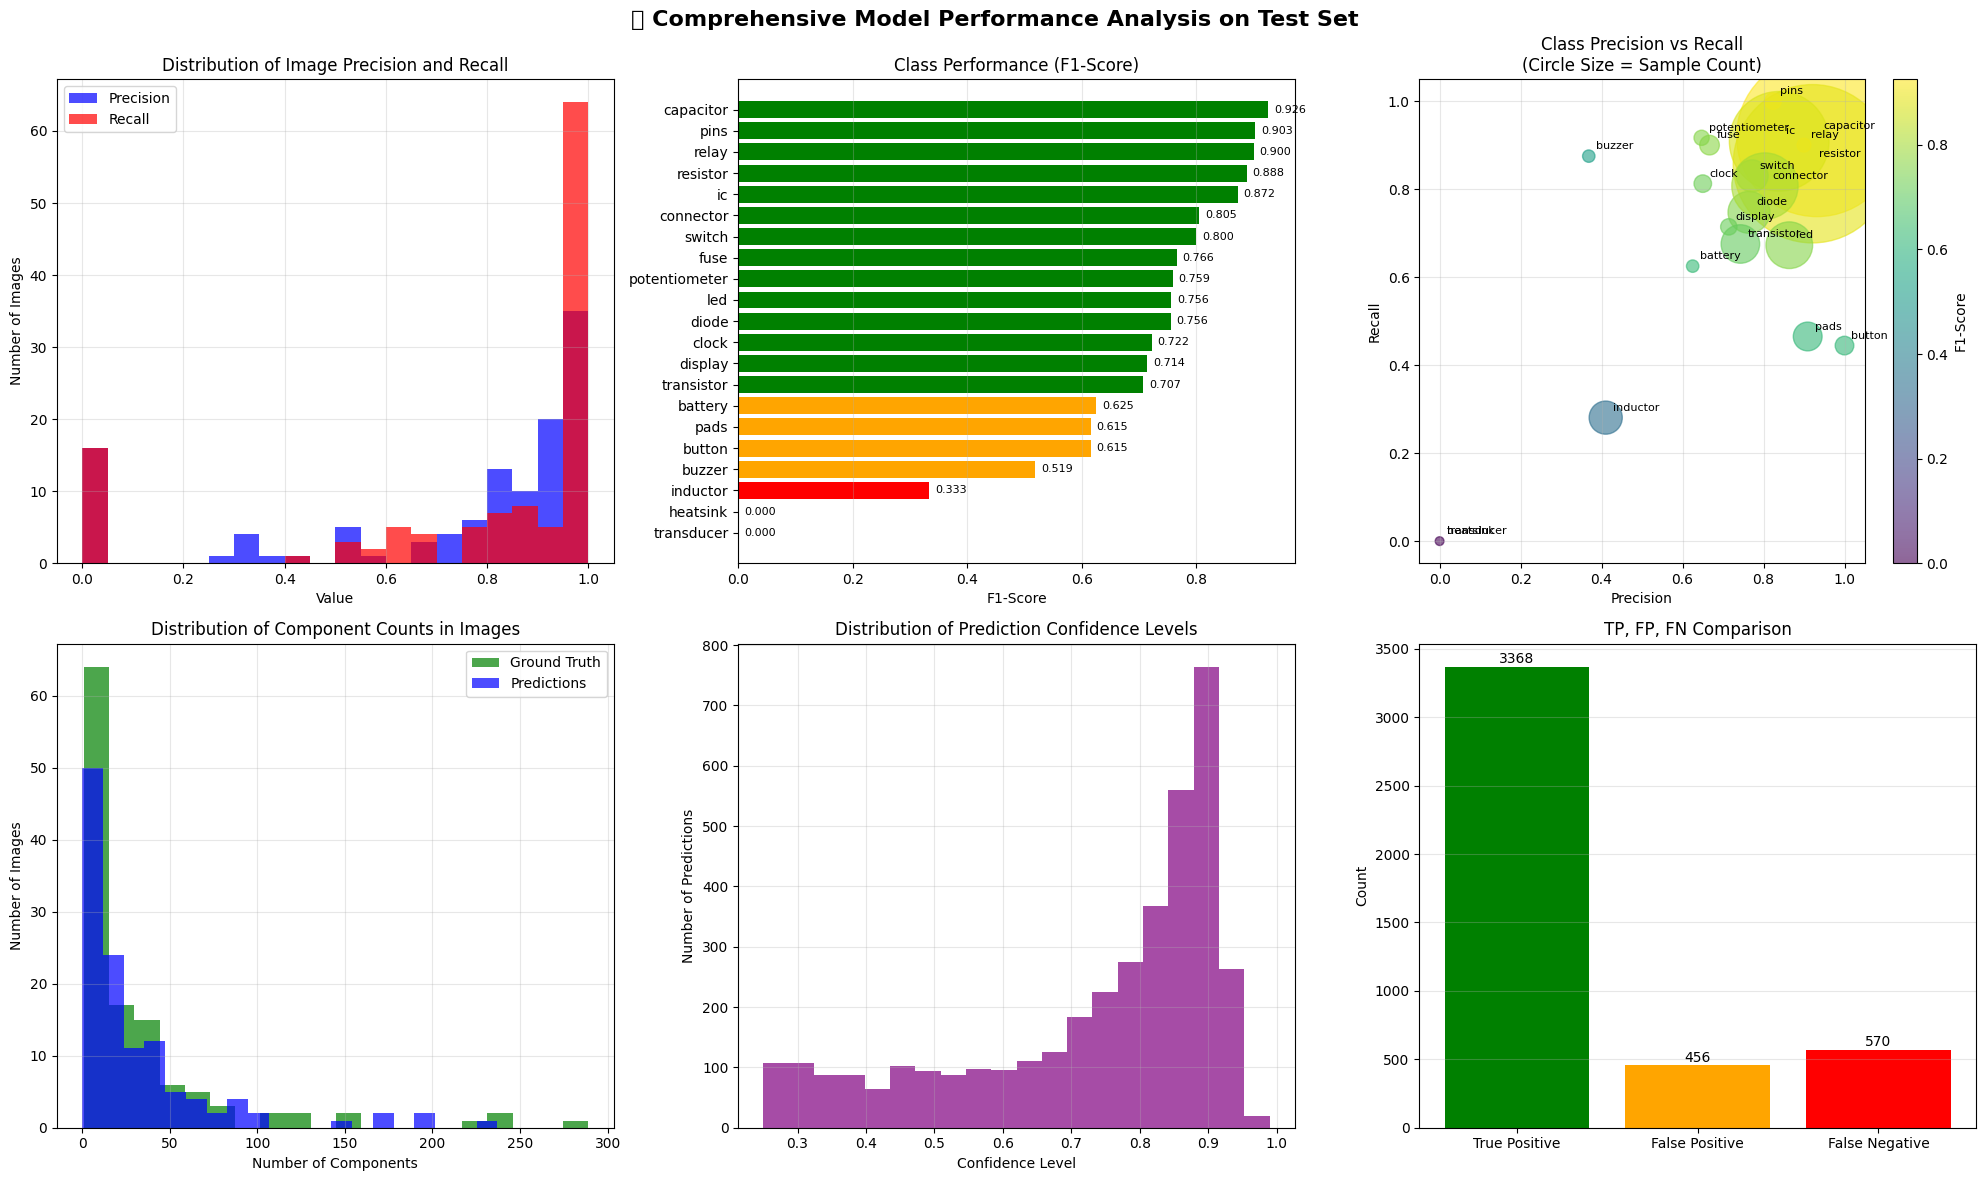


 📈 Comprehensive Model Performance Report

📊 General Statistics:
   • Total Images Analyzed: 120
   • Total True Components: 3938
   • Total Predictions: 3824
   • Total Correct Predictions (Class Match): 3368
   • Average Image Precision: 0.730
   • Average Image Recall: 0.782
   • Average Image F1-Score: 0.746

🎯 Top 5 Performing Classes:
   • capacitor      : F1=0.926, P=0.932, R=0.920
   • pins           : F1=0.903, P=0.824, R=1.000
   • relay          : F1=0.900, P=0.900, R=0.900
   • resistor       : F1=0.888, P=0.921, R=0.858
   • ic             : F1=0.872, P=0.839, R=0.909

⚠️ Worst 5 Performing Classes:
   • pads           : F1=0.615, P=0.909, R=0.465
   • buzzer         : F1=0.519, P=0.368, R=0.875
   • inductor       : F1=0.333, P=0.410, R=0.281
   • heatsink       : F1=0.000, P=0.000, R=0.000
   • transducer     : F1=0.000, P=0.000, R=0.000

📈 Class Performance Distribution:
   • Excellent (F1 ≥ 0.7): 14 classes
   • Good (0.5 ≤ F1 < 0.7): 4 classes
   • Poor (0.3 ≤ F1 < 0

In [ ]:



def read_yolo_labels(label_path, img_width=640, img_height=640):
    """Read a YOLO label file and return bounding boxes in pixel coordinates (xyxy)."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                if len(data) == 5:
                    class_id = int(data[0])
                    # Convert normalized coordinates (0-1) to pixel coordinates
                    x_center = float(data[1]) * img_width
                    y_center = float(data[2]) * img_height
                    width = float(data[3]) * img_width
                    height = float(data[4]) * img_height
                    
                    # Convert to xyxy format (top-left x, y and bottom-right x, y)
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    boxes.append({
                        'class_id': class_id,
                        'class_name': model.names[class_id],
                        'bbox': [x1, y1, x2, y2]
                    })
    return boxes

def analyze_all_test_images():
    """Analyze all images in the test folder using correct paths."""
    test_images_dir = 'components_data_clean/test/images'
    test_labels_dir = 'components_data_clean/test/labels'
    
    # Check for folder existence
    if not os.path.exists(test_images_dir):
        print(f"❌ Images folder not found: {test_images_dir}")
        return [], {}
    
    if not os.path.exists(test_labels_dir):
        print(f"❌ Labels folder not found: {test_labels_dir}")
        return [], {}
    
    # Get all image files
    image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    print(f"🔍 Analyzing {len(image_files)} images in the test set...")
    
    # Store results
    all_results = []
    # Using a simplified counting metric for accuracy (not true IoU matching)
    class_stats = defaultdict(lambda: {'true_count': 0, 'pred_count': 0, 'correct_count': 0}) 
    image_stats = []
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(test_images_dir, image_file)
        label_path = os.path.join(test_labels_dir, os.path.splitext(image_file)[0] + '.txt')
        
        # Read Ground Truth (GT) from labels
        true_boxes = read_yolo_labels(label_path)
        true_classes = [box['class_name'] for box in true_boxes]
        
        # Update class stats for Ground Truth
        for class_name in true_classes:
            class_stats[class_name]['true_count'] += 1
        
        # Model Prediction
        try:
            results = model.predict(source=image_path, conf=0.25, imgsz=1024, verbose=False)
        except Exception as e:
            print(f"❌ Error processing image {image_file}: {e}")
            continue
        
        pred_boxes = []
        for r in results:
            if r.boxes is not None:
                for box in r.boxes:
                    pred_boxes.append({
                        'class_id': int(box.cls[0]),
                        'class_name': model.names[int(box.cls[0])],
                        'bbox': box.xyxy[0].tolist(),
                        'confidence': float(box.conf[0])
                    })
        
        pred_classes = [pred['class_name'] for pred in pred_boxes]
        
        # Update class stats for Predictions
        for class_name in pred_classes:
            class_stats[class_name]['pred_count'] += 1
        
        # Calculate Correct Detections (simplified class matching)
        correct_detections = 0
        temp_true = true_classes.copy()
        
        for pred_class in pred_classes:
            if pred_class in temp_true:
                correct_detections += 1
                temp_true.remove(pred_class) # Prevent double counting for one GT box
                class_stats[pred_class]['correct_count'] += 1
        
        # Calculate Precision and Recall
        precision = correct_detections / len(pred_boxes) if len(pred_boxes) > 0 else 0
        recall = correct_detections / len(true_boxes) if len(true_boxes) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Save image statistics
        image_stats.append({
            'image': image_file,
            'true_count': len(true_boxes),
            'pred_count': len(pred_boxes),
            'correct_count': correct_detections,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        })
        
        if (i + 1) % 10 == 0:
            print(f"📊 Processed {i + 1}/{len(image_files)} images")
    
    return image_stats, class_stats

def plot_comprehensive_analysis(image_stats, class_stats):
    """Plot comprehensive analysis graphs."""
    
    # Convert data to DataFrame
    df_images = pd.DataFrame(image_stats)
    df_classes = pd.DataFrame([
        {
            'class': class_name,
            # Calculate metrics for the class
            'precision': stats['correct_count'] / stats['pred_count'] if stats['pred_count'] > 0 else 0,
            'recall': stats['correct_count'] / stats['true_count'] if stats['true_count'] > 0 else 0,
            # F1-Score calculation based on class counts
            'f1_score': 2 * (stats['correct_count'] / stats['pred_count'] * stats['correct_count'] / stats['true_count']) / 
                        (stats['correct_count'] / stats['pred_count'] + stats['correct_count'] / stats['true_count']) 
                        if (stats['pred_count'] > 0 and stats['true_count'] > 0 and (stats['correct_count'] / stats['pred_count'] + stats['correct_count'] / stats['true_count']) > 0) else 0,
            'true_count': stats['true_count'],
            'pred_count': stats['pred_count'],
            'correct_count': stats['correct_count']
        }
        for class_name, stats in class_stats.items()
    ])
    
    # Create plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('📊 Comprehensive Model Performance Analysis on Test Set', fontsize=16, fontweight='bold')
    
    # Plot 1: Distribution of Precision and Recall for Images
    axes[0, 0].hist(df_images['precision'], bins=20, alpha=0.7, color='blue', label='Precision')
    axes[0, 0].hist(df_images['recall'], bins=20, alpha=0.7, color='red', label='Recall')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Number of Images')
    axes[0, 0].set_title('Distribution of Image Precision and Recall')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Class Performance (F1-Score)
    df_classes_sorted = df_classes.sort_values('f1_score', ascending=True)
    bars = axes[0, 1].barh(df_classes_sorted['class'], df_classes_sorted['f1_score'], 
                             color=['green' if f1 > 0.7 else 'orange' if f1 > 0.5 else 'red' 
                                     for f1 in df_classes_sorted['f1_score']])
    axes[0, 1].set_xlabel('F1-Score')
    axes[0, 1].set_title('Class Performance (F1-Score)')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Add values on bars
    for bar, score in zip(bars, df_classes_sorted['f1_score']):
        axes[0, 1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                         f'{score:.3f}', ha='left', va='center', fontsize=8)
    
    # Plot 3: Precision vs Recall for Classes
    scatter = axes[0, 2].scatter(df_classes['precision'], df_classes['recall'], 
                                 s=df_classes['true_count'] * 10, alpha=0.6, 
                                 c=df_classes['f1_score'], cmap='viridis')
    axes[0, 2].set_xlabel('Precision')
    axes[0, 2].set_ylabel('Recall')
    axes[0, 2].set_title('Class Precision vs Recall\n(Circle Size = Sample Count)')
    axes[0, 2].grid(alpha=0.3)
    
    # Add class names
    for i, class_name in enumerate(df_classes['class']):
        axes[0, 2].annotate(class_name, (df_classes['precision'].iloc[i], df_classes['recall'].iloc[i]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add color bar
    plt.colorbar(scatter, ax=axes[0, 2], label='F1-Score')
    
    # Plot 4: Component Count Distribution in Images
    axes[1, 0].hist(df_images['true_count'], bins=20, alpha=0.7, color='green', label='Ground Truth')
    axes[1, 0].hist(df_images['pred_count'], bins=20, alpha=0.7, color='blue', label='Predictions')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Number of Images')
    axes[1, 0].set_title('Distribution of Component Counts in Images')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 5: Confidence Distribution of Predictions
    confidence_data = []
    # NOTE: The path for image prediction here is different from test_images_dir, adjust if needed.
    test_images_dir_conf = r'F:\machine learning_SFIC\pcb_component\components_data_clean\test\images'
    
    for image_file in df_images['image']:
        image_path = os.path.join(test_images_dir_conf, image_file)
        try:
            # Re-predict to get confidence scores
            results = model.predict(source=image_path, conf=0.25, imgsz=1024, verbose=False) 
            
            for r in results:
                if r.boxes is not None:
                    for box in r.boxes:
                        confidence_data.append(float(box.conf[0]))
        except Exception as e:
            print(f"❌ Error calculating confidence for image {image_file}: {e}")
            continue
    
    if confidence_data:
        axes[1, 1].hist(confidence_data, bins=20, alpha=0.7, color='purple')
        axes[1, 1].set_xlabel('Confidence Level')
        axes[1, 1].set_ylabel('Number of Predictions')
        axes[1, 1].set_title('Distribution of Prediction Confidence Levels')
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Confidence Data Available', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Distribution of Prediction Confidence Levels')
    
    # Plot 6: Comparison of TP, FP, FN
    total_tp = df_images['correct_count'].sum()
    total_fp = df_images['pred_count'].sum() - total_tp
    total_fn = df_images['true_count'].sum() - total_tp
    
    categories = ['True Positive', 'False Positive', 'False Negative']
    values = [total_tp, total_fp, total_fn]
    colors = ['green', 'orange', 'red']
    
    bars = axes[1, 2].bar(categories, values, color=colors)
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('TP, FP, FN Comparison')
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars, values):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                         f'{value}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return df_images, df_classes

def print_summary_statistics(df_images, df_classes):
    """Print summarized statistics."""
    print("\n" + "=" * 70)
    print(" 📈 Comprehensive Model Performance Report")
    print("=" * 70)
    
    # General Statistics
    total_images = len(df_images)
    total_true_components = df_images['true_count'].sum()
    total_pred_components = df_images['pred_count'].sum()
    total_correct = df_images['correct_count'].sum()
    
    avg_precision = df_images['precision'].mean()
    avg_recall = df_images['recall'].mean()
    avg_f1 = df_images['f1_score'].mean()
    
    print(f"\n📊 General Statistics:")
    print(f"   • Total Images Analyzed: {total_images}")
    print(f"   • Total True Components: {total_true_components}")
    print(f"   • Total Predictions: {total_pred_components}")
    print(f"   • Total Correct Predictions (Class Match): {total_correct}")
    print(f"   • Average Image Precision: {avg_precision:.3f}")
    print(f"   • Average Image Recall: {avg_recall:.3f}")
    print(f"   • Average Image F1-Score: {avg_f1:.3f}")
    
    # Top 5 and Worst 5 Classes
    df_classes_sorted = df_classes.sort_values('f1_score', ascending=False)
    
    print(f"\n🎯 Top 5 Performing Classes:")
    for i, row in df_classes_sorted.head().iterrows():
        print(f"   • {row['class']:15}: F1={row['f1_score']:.3f}, P={row['precision']:.3f}, R={row['recall']:.3f}")
    
    print(f"\n⚠️ Worst 5 Performing Classes:")
    for i, row in df_classes_sorted.tail().iterrows():
        print(f"   • {row['class']:15}: F1={row['f1_score']:.3f}, P={row['precision']:.3f}, R={row['recall']:.3f}")
    
    # Performance Distribution
    excellent = len(df_classes[df_classes['f1_score'] >= 0.7])
    good = len(df_classes[(df_classes['f1_score'] >= 0.5) & (df_classes['f1_score'] < 0.7)])
    poor = len(df_classes[(df_classes['f1_score'] >= 0.3) & (df_classes['f1_score'] < 0.5)])
    very_poor = len(df_classes[df_classes['f1_score'] < 0.3])
    
    print(f"\n📈 Class Performance Distribution:")
    print(f"   • Excellent (F1 ≥ 0.7): {excellent} classes")
    print(f"   • Good (0.5 ≤ F1 < 0.7): {good} classes")
    print(f"   • Poor (0.3 ≤ F1 < 0.5): {poor} classes")
    print(f"   • Critical (F1 < 0.3): {very_poor} classes")

# Run the Comprehensive Analysis
print("🔍 Starting comprehensive analysis of all test images...")
image_stats, class_stats = analyze_all_test_images()

if image_stats:
    df_images, df_classes = plot_comprehensive_analysis(image_stats, class_stats)
    print_summary_statistics(df_images, df_classes)
    
    # Save results to file
    output_dir = 'results'
    os.makedirs(output_dir, exist_ok=True)
    
    df_images.to_csv(os.path.join(output_dir, 'test_images_analysis.csv'), index=False, encoding='utf-8')
    df_classes.to_csv(os.path.join(output_dir, 'test_classes_analysis.csv'), index=False, encoding='utf-8')
    print(f"\n💾 Results saved to: {output_dir}")
else:
    print("❌ No images found for analysis")